## Import library

In [1]:
import datetime 
from datetime import timedelta 
import os
import glob
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import roc_curve
from torch import nn, optim

import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from itertools import cycle
from tqdm.notebook import tqdm
import re
from sklearn.metrics import roc_auc_score, plot_roc_curve

import matplotlib.pyplot as plt
import seaborn
from collections import defaultdict

from sklearn import svm

import matplotlib.font_manager as fm
import seaborn as sns
from itertools import product

## Data load

In [2]:
# df_israel_covid 이스라엘 데이터셋
# corona_isolation_per_day_ver_0059 일일 코로나 격리자 수 
# time_series_covid19_confirmed_global 누적 확진자 수 

base_path = './opendataset'
df_israel_covid = pd.read_csv(f'{base_path}/israel_covid_large_2.csv')
# df_israel_covid = pd.read_csv(f'{base_path}/israel_covid_small.csv')
df_israel_isolation_per_day = pd.read_csv(f'{base_path}/corona_isolation_per_day_ver_0069.csv')
df_timeseries_confirm = pd.read_csv(f'{base_path}/time_series_covid19_confirmed_global.csv')

/home/md/anaconda3/envs/flu_screening/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df_confirmed_global = df_timeseries_confirm.sum().reset_index()

In [4]:
df_confirmed_global = df_confirmed_global.rename(columns={'index': 'global_confirmed_date', 0: 'global_confirmed_numsum'}).iloc[3:, :]

In [5]:
df_confirmed_global = df_confirmed_global.reset_index(drop=True)

In [6]:
df_confirmed_global

,global_confirmed_date,global_confirmed_numsum
0,1/22/20,557
1,1/23/20,655
2,1/24/20,941
3,1/25/20,1433
4,1/26/20,2118
...,...,...
589,9/2/21,219062869
590,9/3/21,219821446
591,9/4/21,220282354
592,9/5/21,220689611


In [7]:
df_confirmed_global['global_confirmed_num'] = df_confirmed_global['global_confirmed_numsum'] - df_confirmed_global.shift(1)['global_confirmed_numsum']
df_confirmed_global = df_confirmed_global.dropna()
df_confirmed_global['global_confirmed_num'] = df_confirmed_global['global_confirmed_num'].astype(int)

<ipython-input-7-dfada257fb77>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_confirmed_global['global_confirmed_num'] = df_confirmed_global['global_confirmed_num'].astype(int)


In [8]:
def filter_date(date):
    year = f"20{date[-2:]}"
    month = date[:date.index('/')]
    month = f'0{month}' if len(month) == 1 else month
    day = date[date.index('/') + 1 : date.rindex('/')]
    day = f'0{day}' if len(day) == 1 else day
    res = f'{year}-{month}-{day}'
    return res

In [9]:
df_confirmed_global['global_confirmed_date'] = df_confirmed_global['global_confirmed_date'].apply(filter_date)

<ipython-input-9-62bcef823a49>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_confirmed_global['global_confirmed_date'] = df_confirmed_global['global_confirmed_date'].apply(filter_date)


## preprocessing

In [205]:
# 누적 확진자수를 2021-08-17 와 같은 포멧으로 전처리해주는 과정

rows = []
for idx, values in enumerate(df_timeseries_confirm[df_timeseries_confirm['Country/Region'] == 'Israel'].iteritems()):
    if idx < 4: continue
    year = f"20{values[0][-2:]}"
    month = values[0][:values[0].index('/')]
    month = f'0{month}' if len(month) == 1 else month
    day = values[0][values[0].index('/') + 1 : values[0].rindex('/')]
    day = f'0{day}' if len(day) == 1 else day
    date = f'{year}-{month}-{day}'
    confirmed_num = values[1].item()
    rows.append([date, confirmed_num])
df_numsum_confirmed = pd.DataFrame(rows, columns=['confirmed_date', 'confirmed_numsum'])

In [206]:
# 누적 확진자를 통해 일일 확진자 구하기

df_numsum_confirmed['confirmed_num'] = df_numsum_confirmed['confirmed_numsum'] - df_numsum_confirmed.shift(1)['confirmed_numsum']
df_numsum_confirmed = df_numsum_confirmed.dropna()
df_numsum_confirmed['confirmed_num'] = df_numsum_confirmed['confirmed_num'].astype(int)

In [207]:
# 일일 확진자수가 음수인 경우 그 전날 확진자를 가져다 쓰는 과정

for idx, row in df_numsum_confirmed[df_numsum_confirmed['confirmed_num'] < 0].iterrows():
    print("before", df_numsum_confirmed.loc[idx,'confirmed_num'])
    df_numsum_confirmed.loc[idx,'confirmed_num'] = df_numsum_confirmed.loc[idx-1,'confirmed_num']
    print("after", df_numsum_confirmed.loc[idx,'confirmed_num'])
    print()

before -28
after 28

before -53
after 34



In [208]:
df_numsum_confirmed.head(5)
# df_numsum_confirmed.tail(5)

,confirmed_date,confirmed_numsum,confirmed_num
1,2020-01-23,0,0
2,2020-01-24,0,0
3,2020-01-25,0,0
4,2020-01-26,0,0
5,2020-01-27,0,0


In [209]:
df_israel_covid = df_israel_covid[df_israel_covid['test_date'] < '2021-09-01']
df_israel_isolation_per_day = df_israel_isolation_per_day[df_israel_isolation_per_day['date'] < '2021-09-01']
df_numsum_confirmed = df_numsum_confirmed[df_numsum_confirmed['confirmed_date'] < '2021-06-01']
df_confirmed_global = df_confirmed_global[df_confirmed_global['global_confirmed_date'] < '2021-06-01']

In [210]:
df_israel_isolation_per_day['join_date'] = (pd.to_datetime(df_israel_isolation_per_day['date']) + timedelta(days=1)).dt.strftime('%Y-%m-%d')

# 요일을 숫자로 기록한 컬럼 하나 만듬
df_israel_covid['weekday'] = pd.to_datetime(df_israel_covid['test_date']).dt.dayofweek

In [211]:
# 기존 이스라엘 데이터에 격리자 컬럼을 넣어주는 과정

df_israel_covid = pd.merge(df_israel_covid, df_israel_isolation_per_day, how='left', left_on='test_date', right_on='join_date')

In [212]:
df_israel_covid = df_israel_covid.sort_values('test_date')
df_israel_covid.head(5)

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,weekday,date,isolated_today_contact_with_confirmed,isolated_today_abroad,new_contact_with_confirmed,new_from_abroad,join_date
6925780,2020-03-11,0,0,0,0,0,שלילי,NaN,זכר,Other,2,2020-03-10,3715,20792,2154,3638,2020-03-11
6925531,2020-03-11,1,0,1,0,0,שלילי,NaN,נקבה,Abroad,2,2020-03-10,3715,20792,2154,3638,2020-03-11
6925532,2020-03-11,1,0,0,1,0,שלילי,NaN,נקבה,Other,2,2020-03-10,3715,20792,2154,3638,2020-03-11
6925533,2020-03-11,0,0,0,0,0,שלילי,NaN,זכר,Other,2,2020-03-10,3715,20792,2154,3638,2020-03-11
6925534,2020-03-11,0,0,0,0,0,שלילי,NaN,נקבה,Other,2,2020-03-10,3715,20792,2154,3638,2020-03-11


In [213]:
# 기존 이스라엘 데이터에 이스라엘 일일 확진자랑 일일 누적 확진자 컬럼을 넣어주는 과정

df_israel_covid = pd.merge(df_israel_covid, df_numsum_confirmed, how='left', left_on='test_date', right_on='confirmed_date')

In [214]:
# 기존 이스라엘 데이터에 글로벌 일일 확진자랑 일일 누적 확진자 컬럼을 넣어주는 과정

df_israel_covid = pd.merge(df_israel_covid, df_confirmed_global, how='left', left_on='test_date', right_on='global_confirmed_date')

In [215]:
df_israel_covid

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,...,isolated_today_abroad,new_contact_with_confirmed,new_from_abroad,join_date,confirmed_date,confirmed_numsum,confirmed_num,global_confirmed_date,global_confirmed_numsum,global_confirmed_num
0,2020-03-11,0,0,0,0,0,שלילי,NaN,זכר,Other,...,20792,2154,3638,2020-03-11,2020-03-11,60.0,28.0,2020-03-11,126719,7667.0
1,2020-03-11,1,0,1,0,0,שלילי,NaN,נקבה,Abroad,...,20792,2154,3638,2020-03-11,2020-03-11,60.0,28.0,2020-03-11,126719,7667.0
2,2020-03-11,1,0,0,1,0,שלילי,NaN,נקבה,Other,...,20792,2154,3638,2020-03-11,2020-03-11,60.0,28.0,2020-03-11,126719,7667.0
3,2020-03-11,0,0,0,0,0,שלילי,NaN,זכר,Other,...,20792,2154,3638,2020-03-11,2020-03-11,60.0,28.0,2020-03-11,126719,7667.0
4,2020-03-11,0,0,0,0,0,שלילי,NaN,נקבה,Other,...,20792,2154,3638,2020-03-11,2020-03-11,60.0,28.0,2020-03-11,126719,7667.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6925776,2021-08-31,0,0,0,0,0,שלילי,No,זכר,Other,...,76593,6446,8006,2021-08-31,NaN,NaN,NaN,NaN,NaN,NaN
6925777,2021-08-31,0,0,0,0,0,שלילי,Yes,זכר,Other,...,76593,6446,8006,2021-08-31,NaN,NaN,NaN,NaN,NaN,NaN
6925778,2021-08-31,0,0,0,0,0,שלילי,No,נקבה,Other,...,76593,6446,8006,2021-08-31,NaN,NaN,NaN,NaN,NaN,NaN
6925779,2021-08-31,0,0,0,0,0,שלילי,No,נקבה,Other,...,76593,6446,8006,2021-08-31,NaN,NaN,NaN,NaN,NaN,NaN


In [216]:
df_israel_covid.shape[0]

6925781

In [217]:
head_ne = df_israel_covid[df_israel_covid['head_ache'] == 0]
head_po = df_israel_covid[df_israel_covid['head_ache'] == 1]
print(head_ne.shape[0]+head_po.shape[0])

6925781


In [227]:
head_po[head_po['test_indication'] == 'Abroad'].shape[0]

1537

In [228]:
head_po[head_po['test_indication'] == 'Other'].shape[0]

101895

In [229]:
head_po[head_po['test_indication'] == 'Contact with confirmed'].shape[0]

118827

In [230]:
head_ne[head_ne['test_indication'] == 'Abroad'].shape[0]

24112

In [231]:
head_ne[head_ne['test_indication'] == 'Other'].shape[0]

6310452

In [232]:
head_ne[head_ne['test_indication'] == 'Contact with confirmed'].shape[0]

368958

## 번역하기

In [218]:
def gender_map(gender):
    if gender == 'נקבה': return 1 #'Female'
    elif gender == 'זכר': return 0 #'Male'
    return -1

In [219]:
def corona_result_map(corona_result):
    if corona_result == 'אחר': return -1 # 'Other'
    elif corona_result == 'שלילי': return 0 # 'Negative'
    elif corona_result == 'חיובי': return 1 # 'Positive'
    return ''

In [220]:
def corona_result_map_vis(corona_result):
    if corona_result == -1: return 'Other'
    elif corona_result == 0: return 'Negative' 
    elif corona_result == 1: return 'Positive' 
    return ''

In [221]:
def age_60_and_above_map(age_60_and_above):
    if age_60_and_above == 'Yes': return 1
    elif age_60_and_above == 'No': return 0
    return -1

In [222]:
def test_indication_map(test_indication):
    if test_indication == 'Other': return 0
    elif test_indication == 'Abroad': return 1
    elif  test_indication == 'Contact with confirmed': return 2
    else: return -1

In [223]:
df_israel_covid['gender'] = df_israel_covid['gender'].apply(gender_map)
df_israel_covid['corona_result'] = df_israel_covid['corona_result'].apply(corona_result_map)
df_israel_covid['age_60_and_above'] = df_israel_covid['age_60_and_above'].apply(age_60_and_above_map)
df_israel_covid['test_indication'] = df_israel_covid['test_indication'].apply(test_indication_map)

In [34]:
df_israel_covid['indication_other'] = df_israel_covid['test_indication'].apply(lambda x : 1 if x == 0 else 0)
df_israel_covid['indication_abroad'] = df_israel_covid['test_indication'].apply(lambda x : 1 if x == 1 else 0)
df_israel_covid['indication_contact'] = df_israel_covid['test_indication'].apply(lambda x : 1 if x == 2 else 0)

## model input preprocessing

In [38]:
# other 빼버림
df_israel_covid_without_o = df_israel_covid[df_israel_covid['corona_result'] != -1]

In [39]:
df_israel_covid_without_o.shape[0]

6776916

In [40]:
# 성별 없는 사람들 빼버림
df_israel_covid_without_o = df_israel_covid_without_o[df_israel_covid_without_o['gender'] != -1]

In [41]:
df_israel_covid_without_o.shape[0]

6275088

In [42]:
df_israel_covid_without_o = df_israel_covid_without_o.sort_values(['test_date']).reset_index(drop=True)

In [43]:
df_israel_covid_without_o['test_date'].min()

'2020-03-11'

In [44]:
# # week_num 이라는 칼럼을 새로 만들었다. 1년에 52주라 
# def date_to_weeknum_map(test_date):
#     week_num_st_idx = 52
#     year_last_num = int(test_date[2:4])
#     week_num = datetime.date(int(test_date[:4]), int(test_date[5:7]), int(test_date[8:])).isocalendar()[1]
#     return week_num_st_idx * year_last_num + week_num

# Add 2nd degree data
추가 feature
- new_contact_with_confirmed
- positive_ratio
- weekday_ratio
- confirmed_ratio

In [45]:
df_israel_covid_without_o['new_contact_with_confirmed'] = df_israel_covid_without_o['new_contact_with_confirmed'].astype(int)

In [46]:
df_israel_covid_without_o['contact'] = df_israel_covid_without_o['new_contact_with_confirmed'] / df_israel_covid_without_o['new_contact_with_confirmed'].max()

In [47]:
df_confirm_by_sampling = df_israel_covid_without_o[df_israel_covid_without_o['corona_result'] == 1].groupby('test_date').count().reset_index()[['test_date', 'date']]
df_confirm_by_sampling = df_confirm_by_sampling.rename(columns={'test_date': 'yesterday', 'date': 'positive_cnt'})

In [48]:
df_israel_covid_without_o = pd.merge(df_israel_covid_without_o, df_confirm_by_sampling, how='left', left_on='date', right_on='yesterday')

In [49]:
df_israel_covid_without_o.shape[0]

6275088

In [50]:
df_israel_covid_without_o = df_israel_covid_without_o[~df_israel_covid_without_o['positive_cnt'].isnull()]

In [51]:
df_israel_covid_without_o['positive_cnt'] = df_israel_covid_without_o['positive_cnt'].astype(int)

In [52]:
df_israel_covid_without_o['positive_ratio'] = df_israel_covid_without_o['positive_cnt'] / df_israel_covid_without_o['positive_cnt'].max()

In [53]:
df_israel_covid_without_o['weekday_ratio'] = df_israel_covid_without_o['weekday'] / 6

In [54]:
df_israel_covid_without_o['confirmed_ratio'] = df_israel_covid_without_o['confirmed_num'] / df_israel_covid_without_o['confirmed_num'].max()

In [55]:
df_israel_covid_without_o['global_confirmed_ratio'] = df_israel_covid_without_o['global_confirmed_num'] / df_israel_covid_without_o['global_confirmed_num'].max()

In [56]:
df_israel_covid_without_o['confirmed_num'].max()

11934.0

In [190]:
df_israel_covid_without_o[['test_indication', 'indication_other', 'indication_abroad', 'indication_contact']].head(30)

,test_indication,indication_other,indication_abroad,indication_contact
361,0,1,0,0
362,0,1,0,0
363,0,1,0,0
364,0,1,0,0
365,0,1,0,0
366,0,1,0,0
367,0,1,0,0
368,0,1,0,0
369,0,1,0,0
370,0,1,0,0


In [58]:
df_israel_covid_without_o.columns

Index(['test_date', 'cough', 'fever', 'sore_throat', 'shortness_of_breath',
       'head_ache', 'corona_result', 'age_60_and_above', 'gender',
       'test_indication', 'weekday', 'date',
       'isolated_today_contact_with_confirmed', 'isolated_today_abroad',
       'new_contact_with_confirmed', 'new_from_abroad', 'join_date',
       'confirmed_date', 'confirmed_numsum', 'confirmed_num',
       'global_confirmed_date', 'global_confirmed_numsum',
       'global_confirmed_num', 'indication_other', 'indication_abroad',
       'indication_contact', 'contact', 'yesterday', 'positive_cnt',
       'positive_ratio', 'weekday_ratio', 'confirmed_ratio',
       'global_confirmed_ratio'],
      dtype='object')

In [59]:
df_israel_covid_without_o = df_israel_covid_without_o[~df_israel_covid_without_o['confirmed_ratio'].isnull()]

In [60]:
df_israel_covid_without_o['year'] = df_israel_covid_without_o['test_date'].apply(lambda x: int(x[:4]))
df_israel_covid_without_o['month'] = df_israel_covid_without_o['test_date'].apply(lambda x: int(x[5:7]))
df_israel_covid_without_o['day'] = df_israel_covid_without_o['test_date'].apply(lambda x: int(x[8:10]))

In [61]:
# 여기서 내가 사용할 feature 고르기
df_input_only_symptom = df_israel_covid_without_o[['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'corona_result']]
df_input = df_israel_covid_without_o[['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'gender', 'confirmed_ratio', 'global_confirmed_ratio', 'indication_other', 'indication_abroad', 'indication_contact', 'corona_result']]

raw_datas_only_symptom = df_input_only_symptom.values
raw_datas = df_input.values

In [62]:
df_israel_covid_without_o

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,...,contact,yesterday,positive_cnt,positive_ratio,weekday_ratio,confirmed_ratio,global_confirmed_ratio,year,month,day
361,2020-03-12,1,1,1,1,0,0,-1,1,0,...,0.056174,2020-03-11,42,0.007795,0.5,0.001760,0.003864,2020,3,12
362,2020-03-12,0,0,0,0,0,0,-1,0,0,...,0.056174,2020-03-11,42,0.007795,0.5,0.001760,0.003864,2020,3,12
363,2020-03-12,0,0,0,0,0,0,-1,1,0,...,0.056174,2020-03-11,42,0.007795,0.5,0.001760,0.003864,2020,3,12
364,2020-03-12,0,0,0,0,0,0,-1,1,0,...,0.056174,2020-03-11,42,0.007795,0.5,0.001760,0.003864,2020,3,12
365,2020-03-12,0,0,0,0,0,0,-1,1,0,...,0.056174,2020-03-11,42,0.007795,0.5,0.001760,0.003864,2020,3,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5375922,2021-04-22,0,0,0,0,0,0,-1,1,0,...,0.018237,2021-04-21,42,0.007795,0.5,0.026395,0.600431,2021,4,22
5375923,2021-04-22,0,0,0,0,0,0,-1,1,0,...,0.018237,2021-04-21,42,0.007795,0.5,0.026395,0.600431,2021,4,22
5375924,2021-04-22,0,0,0,0,0,0,-1,0,0,...,0.018237,2021-04-21,42,0.007795,0.5,0.026395,0.600431,2021,4,22
5375925,2021-04-22,0,0,0,0,0,0,-1,0,0,...,0.018237,2021-04-21,42,0.007795,0.5,0.026395,0.600431,2021,4,22


In [63]:
df_input.describe()

,cough,fever,sore_throat,shortness_of_breath,head_ache,gender,confirmed_ratio,global_confirmed_ratio,indication_other,indication_abroad,indication_contact,corona_result
count,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06
mean,4.963493e-02,3.851017e-02,1.842978e-02,4.828174e-03,3.798640e-02,5.207305e-01,2.597199e-01,2.824709e-01,9.119273e-01,4.229586e-03,8.384312e-02,7.944592e-02
std,2.171896e-01,1.924244e-01,1.344995e-01,6.931713e-02,1.911634e-01,4.995701e-01,2.258918e-01,1.453237e-01,2.834006e-01,6.489759e-02,2.771524e-01,2.704335e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.863713e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.315234e-02,1.754418e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.680912e-01,2.741507e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,4.026311e-01,3.930446e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [64]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)).astype(int)
    test_set_size = int(len(data) * test_ratio)
    
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    print(len(data))
    print(test_indices.dtype)
    print(train_indices.dtype)
    
    test_data = data[:test_set_size]
    train_data = data[test_set_size:]
    test_data = data[test_indices]
    train_data = data[train_indices]
    
    return train_data, test_data

In [65]:
def split_input_gt(non_split_data):
    splited_input = non_split_data[:, :-1]
    splited_gt = non_split_data[:, -1]
    
    return splited_input, splited_gt

In [66]:
not_test_datas, test_datas = split_train_test(raw_datas, test_ratio=0.2)
train_datas, valid_datas = split_train_test(not_test_datas, test_ratio=0.2)

train_input, train_gt = split_input_gt(train_datas)
valid_input, valid_gt = split_input_gt(valid_datas)
test_input, test_gt = split_input_gt(test_datas)

5345913
int64
int64
4276731
int64
int64


In [67]:
not_test_datas_only_symptom, test_datas_only_symptom = split_train_test(raw_datas_only_symptom, test_ratio=0.2)
train_datas_only_symptom, valid_datas_only_symptom = split_train_test(not_test_datas_only_symptom, test_ratio=0.2)

train_input_only_symptom, train_gt_only_symptom = split_input_gt(train_datas_only_symptom)
valid_input_only_symptom, valid_gt_only_symptom = split_input_gt(valid_datas_only_symptom)
test_input_only_symptom, test_gt_only_symptom = split_input_gt(train_datas_only_symptom)

5345913
int64
int64
4276731
int64
int64


In [68]:
print(train_input.shape, train_gt.shape, valid_input.shape, valid_gt.shape, test_input.shape, test_gt.shape)

(3421385, 11) (3421385,) (855346, 11) (855346,) (1069182, 11) (1069182,)


In [69]:
print(train_input_only_symptom.shape, train_gt_only_symptom.shape, valid_input_only_symptom.shape, valid_gt_only_symptom.shape, test_input_only_symptom.shape, test_gt_only_symptom.shape)

(3421385, 5) (3421385,) (855346, 5) (855346,) (3421385, 5) (3421385,)


In [70]:
train_input.shape

(3421385, 11)

In [71]:
def plot_roc_curve_for_dnn(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

In [72]:
def get_preds_by_rule(input_datas, df_rule):
    preds = []
    for idx, input_data in enumerate(input_datas):
        preds.append(rulebase_classifier(input_data, df_rule))
#         preds = [rulebase_classifier(input_data, df_rule) for input_data in input_datas]
    return np.array(preds, dtype=np.float64)

In [73]:
print("# of train data positive: ", train_gt.sum())
print("# of train data negative: ", train_gt.shape[0] - train_gt.sum())
print("ratio of P/N: ", train_gt.sum()/(train_gt.shape[0] - train_gt.sum()))
print("")

print("# of valid data positive: ", valid_gt.sum())
print("# of valid data negative: ", valid_gt.shape[0] - valid_gt.sum())
print("ratio of P/N: ", valid_gt.sum()/(valid_gt.shape[0] - valid_gt.sum()))
print("")

print("# of test data positive: ", test_gt.sum())
print("# of test data negative: ", test_gt.shape[0] - test_gt.sum())
print("ratio of P/N: ", test_gt.sum()/(test_gt.shape[0] - test_gt.sum()))

# of train data positive:  271925.0
# of train data negative:  3149460.0
ratio of P/N:  0.08634019800219721

# of valid data positive:  67773.0
# of valid data negative:  787573.0
ratio of P/N:  0.0860529754067242

# of test data positive:  85013.0
# of test data negative:  984169.0
ratio of P/N:  0.0863804895297454


In [74]:
class IsraelDataset(Dataset):
    def __init__(self, input_data, gt, transform=None, target_transform=None):
        self.input_data = input_data
        self.gt = gt
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, idx):
        return self.input_data[idx], self.gt[idx]

In [75]:
def plot_roc_curve_for_dnn(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

In [76]:
def display_performance(clf, pred, valid_input, valid_gt, save_name=None):
    pred = np.array(pred)

    print('accuracy %.4f' % (accuracy_score(pred, valid_gt)))
    print('precision %.4f' % (precision_score(pred, valid_gt)))
    print('recall %.4f' % (recall_score(pred, valid_gt)))
    print('f1-score %.4f' % (f1_score(pred, valid_gt)))
    print(confusion_matrix(pred, valid_gt))
    
    plot_roc_curve(clf, valid_input, valid_gt)
    
    if save_name != None: plt.savefig(f'./eda_result/{save_name}.png')

In [77]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

logistic_clf = LogisticRegression(C=1000.0, random_state=0)
logistic_clf = logistic_clf.fit(train_input, train_gt)

accuracy 0.9193
precision 0.1855
recall 0.4766
f1-score 0.2671
[[773770  55202]
 [ 13803  12571]]


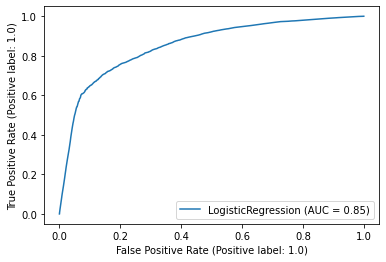

In [78]:
pred = logistic_clf.predict(valid_input)
display_performance(logistic_clf, pred, valid_input, valid_gt, 'logistic_auc')

In [79]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=5, random_state=0)
rf_clf.fit(train_input, train_gt)

RandomForestClassifier(n_estimators=5, random_state=0)

accuracy 0.9286
precision 0.3567
recall 0.5799
f1-score 0.4417
[[770065  43601]
 [ 17508  24172]]


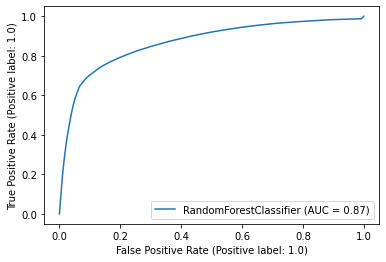

In [80]:
pred = rf_clf.predict(valid_input)
display_performance(rf_clf, pred, valid_input, valid_gt, 'randomforest_auc')

In [135]:
dt_clf = DecisionTreeClassifier(random_state=0)
dt_clf.fit(train_input, train_gt)

DecisionTreeClassifier(random_state=0)

accuracy 0.9292
precision 0.3474
recall 0.5906
f1-score 0.4375
[[771222  44244]
 [ 16325  23555]]


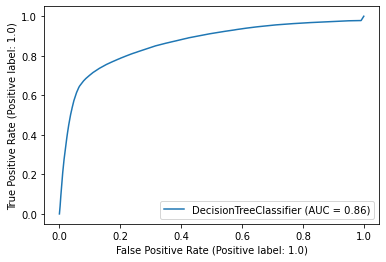

In [136]:
pred = dt_clf.predict(valid_input)
display_performance(dt_clf, pred, valid_input, valid_gt, 'decisiontree_auc')

In [137]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(train_input, train_gt)

GradientBoostingClassifier(random_state=0)

accuracy 0.9251
precision 0.3304
recall 0.5458
f1-score 0.4116
[[768910  45401]
 [ 18637  22398]]


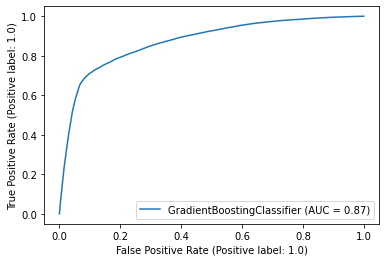

In [138]:
pred = gb_clf.predict(valid_input)
display_performance(gb_clf, pred, valid_input, valid_gt, 'gbm_auc')

In [401]:
df_input.describe()

,cough,fever,sore_throat,shortness_of_breath,head_ache,gender,confirmed_ratio,global_confirmed_ratio,test_indication,corona_result
count,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06,5.345913e+06
mean,4.963493e-02,3.851017e-02,1.842978e-02,4.828174e-03,3.798640e-02,5.207305e-01,2.597199e-01,2.824709e-01,8.384312e-02,7.944592e-02
std,2.171896e-01,1.924244e-01,1.344995e-01,6.931713e-02,1.911634e-01,4.995701e-01,2.258918e-01,1.453237e-01,2.771524e-01,2.704335e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.863713e-03,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.315234e-02,1.754418e-01,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.680912e-01,2.741507e-01,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,4.026311e-01,3.930446e-01,0.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [94]:
a

In [95]:
#  if test_indication == 'Other': return 0
#     elif test_indication == 'Abroad': return 1
#     elif  test_indication == 'Contact with confirmed': return 2

In [96]:
training_data = IsraelDataset(torch.Tensor(train_input), torch.Tensor(train_gt.reshape(-1, 1)))
valid_data = IsraelDataset(torch.Tensor(valid_input), torch.Tensor(valid_gt.reshape(-1, 1)))
test_data = IsraelDataset(torch.Tensor(test_input), torch.Tensor(test_gt.reshape(-1, 1)))
                          
train_dataloader = DataLoader(training_data, batch_size = 512, shuffle=False)
valid_dataloader = DataLoader(valid_data, batch_size=128, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)

train_input.shape, valid_input.shape, test_input.shape

((3421385, 11), (855346, 11), (1069182, 11))

In [97]:
for val_inputs, val_labels in valid_dataloader:
    break
print(val_inputs.shape)

print(val_inputs.shape)

torch.Size([128, 11])
torch.Size([128, 11])


In [98]:
import torch
from torch import Tensor
import torch.nn as nn
from typing import Type, Any, Callable, Union, List, Optional


def conv3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1) -> nn.Conv1d:
    return nn.Conv1d(in_planes, out_planes,
                     kernel_size=3,
                     stride=stride, padding=1,
                     groups=groups, bias=False,
                     )


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(self, inplanes: int, planes: int, stride: int = 1, ) -> None:
        super(BasicBlock, self).__init__()
        norm_layer = nn.BatchNorm1d
        self.conv1 = conv3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes, n_channels=64, dropout=0.2):

        super(ResNet, self).__init__()

        self.inplanes = 1
        self.outplanes = n_channels
        self.conv1 = nn.Conv1d(self.inplanes, self.outplanes, kernel_size=7, stride=1, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(self.outplanes)
        self.relu = nn.ReLU(inplace=True)

        # Update inplanes for the next layer
        self.inplanes = self.outplanes

        # ResNet blocks
        self.layer1 = self._make_layer(block, n_channels, layers[0])
        self.layer2 = self._make_layer(block, n_channels, layers[1], stride=1,)
        self.layer3 = self._make_layer(block, n_channels, layers[2], stride=1,)
        self.layer4 = self._make_layer(block, n_channels, layers[3], stride=1,)
        self.layer5 = self._make_layer(block, n_channels, layers[3], stride=1,)
        self.layer6 = self._make_layer(block, n_channels, layers[3], stride=1,)
        self.layer7 = self._make_layer(block, n_channels, layers[3], stride=1,)
        self.layer8 = self._make_layer(block, n_channels, layers[3], stride=1,)
        self.avgpool = nn.AdaptiveAvgPool1d((1, ))
        
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(self.inplanes * block.expansion, num_classes)

    def _make_layer(self, block, planes: int, blocks: int, stride: int = 1, dilate: bool = False):
        layers = []
        layers.append(block(self.inplanes, planes, stride))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, stride))

        return nn.Sequential(*layers)

    def forward(self, x: Tensor):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [166]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [234]:
model = BaselineModel().to(device)

In [235]:
# model = ResNet(BasicBlock, [2, 2, 2, 2], 1, n_channels=64, dropout=0.9).to(device)

In [236]:
model

BaselineModel(
  (fcs1): Sequential(
    (0): Linear(in_features=11, out_features=400, bias=True)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fcs2): Sequential(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fcs3): Sequential(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fcs4): Sequential(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fcs5): Sequential(
    (0): Linear(in_features=400, out_features=1, bias=True)
  )
)

In [237]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # lr 크기좀 늘려보기

In [238]:
def show_progress(train_history, val_history):
    plt.plot(train_history)
    plt.plot(val_history)
    plt.legend(['train_loss', 'val_loss'])
    plt.show()

In [239]:
import gc

In [243]:
model.load_state_dict(torch.load('./eda_result/base_model_epoch11_v4.pth'))

<All keys matched successfully>

In [244]:
# 'cough', 'fever', 'sore_throat', 'shortness_of_breath', 
# 'head_ache', 'gender', 'confirmed_ratio', 'global_confirmed_ratio', 
# 'indication_other', 'indication_abroad', 'indication_contact', 'corona_result'

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/6683 [00:00<?, ?it/s]

  0%|          | 0/6683 [00:00<?, ?it/s]

[[0.10025561]
 [0.0372918 ]
 [0.5219776 ]
 [0.070514  ]
 [0.06484943]] [[0.]
 [0.]
 [1.]
 [0.]
 [0.]]
Done. Train loss:0.18618408560231117, Validation loss: 0.1870726793419141 VAL_AUC:0.8754072419123606


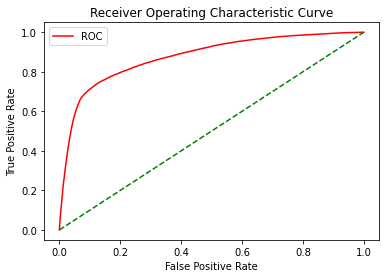

  0%|          | 0/6683 [00:00<?, ?it/s]

/home/md/anaconda3/envs/flu_screening/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  0%|          | 0/6683 [00:00<?, ?it/s]

[[0.11207324]
 [0.03682728]
 [0.5120285 ]
 [0.07005847]
 [0.0656257 ]] [[0.]
 [0.]
 [1.]
 [0.]
 [0.]]
Done. Train loss:0.1861377331345591, Validation loss: 0.18709306824535965 VAL_AUC:0.8753362771271284


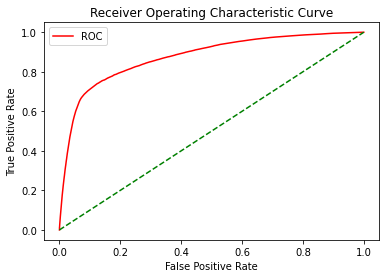

  0%|          | 0/6683 [00:00<?, ?it/s]

/home/md/anaconda3/envs/flu_screening/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  0%|          | 0/6683 [00:00<?, ?it/s]

[[0.1096011 ]
 [0.03766425]
 [0.50054723]
 [0.06799015]
 [0.0647224 ]] [[0.]
 [0.]
 [1.]
 [0.]
 [0.]]
Done. Train loss:0.18608643708338946, Validation loss: 0.18711763688772984 VAL_AUC:0.8752950751190994


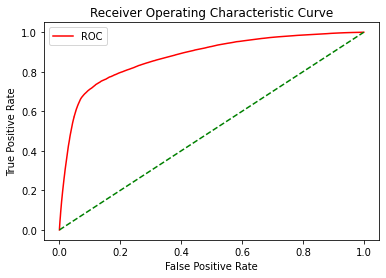

  0%|          | 0/6683 [00:00<?, ?it/s]

/home/md/anaconda3/envs/flu_screening/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  0%|          | 0/6683 [00:00<?, ?it/s]

[[0.11054641]
 [0.03789249]
 [0.49156776]
 [0.07059567]
 [0.06590956]] [[0.]
 [0.]
 [1.]
 [0.]
 [0.]]
Done. Train loss:0.1860356480061571, Validation loss: 0.18715410796025458 VAL_AUC:0.8752545327966597


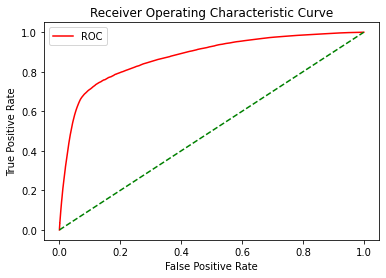

  0%|          | 0/6683 [00:00<?, ?it/s]

/home/md/anaconda3/envs/flu_screening/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


  0%|          | 0/6683 [00:00<?, ?it/s]

[[0.10366401]
 [0.03743891]
 [0.50077295]
 [0.06811266]
 [0.06223131]] [[0.]
 [0.]
 [1.]
 [0.]
 [0.]]
Done. Train loss:0.18598077158812507, Validation loss: 0.1871922387240239 VAL_AUC:0.8752525790320709


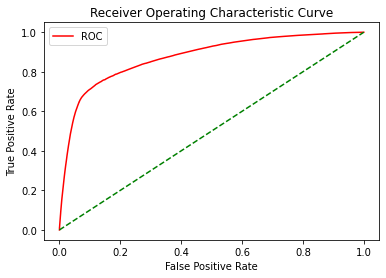

  0%|          | 0/6683 [00:00<?, ?it/s]

/home/md/anaconda3/envs/flu_screening/lib/python3.8/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


KeyboardInterrupt: 

In [262]:
train_running_loss = 0.0
num_epochs = 30

train_history = []
val_history = []
torch.cuda.empty_cache()

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_losses = []
    for train_inputs, train_labels in tqdm(train_dataloader):
        train_inputs = torch.unsqueeze(train_inputs, 1)
        train_inputs = train_inputs.to(device)
        train_labels = train_labels.to(device)

        optimizer.zero_grad()
        
        train_outputs = model(train_inputs)
        train_outputs = nn.functional.sigmoid(train_outputs)
        train_loss = criterion(train_outputs, train_labels)
        train_loss.backward()
        optimizer.step()
        
        ##
#         print('train loss]', train_loss)
        train_losses.append(train_loss.tolist())
    
#     del variables
    torch.cuda.empty_cache()
    
    model.eval()
    
    val_losses = []
    val_all_outputs = []
    val_all_labels = []
    for val_inputs, val_labels in tqdm(valid_dataloader):
        
        val_inputs = torch.unsqueeze(val_inputs, 1)
        val_outputs = model(torch.Tensor(val_inputs).to(device))
        
        val_outputs = torch.sigmoid(val_outputs)
        
        ##
        val_loss_on_batch = criterion(val_outputs, val_labels.to(device))
#         print('valid loss]', val_loss_on_batch)
        
        val_losses.append(val_loss_on_batch.tolist())
        val_all_outputs.append(val_outputs.cpu().detach().numpy())
        val_all_labels.append(val_labels.cpu().detach().numpy())
        
        
    val_all_outputs = np.concatenate(val_all_outputs, axis=0)
    val_all_labels = np.concatenate(val_all_labels, axis=0)
    print(val_all_outputs[:5], val_all_labels[:5])
    auc = roc_auc_score(val_all_labels, val_all_outputs)    
    

    total_val_loss = sum(val_losses) / len(valid_dataloader)
    total_train_loss = sum(train_losses) / len(train_dataloader)
    
    print('Done. Train loss:{}, Validation loss: {} VAL_AUC:{}'.format(total_train_loss, total_val_loss, auc))
    
    fper, tper, thresholds = roc_curve(val_all_labels, val_all_outputs)
    plot_roc_curve_for_dnn(fper, tper)
    
#     print('debug')
#     print(type(total_train_loss))
#     print(type(total_val_loss))
#     train_history.append(total_train_loss)
#     val_history.append(total_val_loss)
#     train_history.append(total_train_loss.cpu().detach().numpy())
#     val_history.append(total_val_loss.cpu().detach().numpy())
    
#     show_progress(train_history, val_history)
    
#     del val_losses
#     del val_all_outputs
#     del val_all_labels
    torch.save(model.state_dict(), f'./eda_result/cnn_model_epoch{epoch+31}_v4.pth')

In [263]:
model.load_state_dict(torch.load('./eda_result/cnn_model_epoch35_v4.pth'))

<All keys matched successfully>

In [264]:
model.eval()

BaselineModel(
  (fcs1): Sequential(
    (0): Linear(in_features=11, out_features=400, bias=True)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fcs2): Sequential(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fcs3): Sequential(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fcs4): Sequential(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fcs5): Sequential(
    (0): Linear(in_features=400, out_features=1, bias=True)
  )
)

In [328]:
# 11934
# model = BaselineModel().to(device)
# 'cough', 'fever', 'sore_throat', 'shortness_of_breath', 
# 'head_ache', 'gender', 'confirmed_ratio', 'global_confirmed_ratio', 
# 'indication_other', 'indication_abroad', 'indication_contact'
mock_input = torch.Tensor([[1, 0, 0, 0, 0, 0, 0.6, 0.8, 1, 0, 0]]).to(device)
mock_input = torch.unsqueeze(mock_input, 1)

torch.sigmoid(model(mock_input))

tensor([[0.5349]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [266]:
#  if test_indication == 'Other': return 0
#     elif test_indication == 'Abroad': return 1
#     elif  test_indication == 'Contact with confirmed': return 2

In [321]:
symp_other_x = []
symp_other_y = []

symp_abroad_x = []
symp_abroad_y = []

symp_contact_x = []
symp_contact_y = []

for i in range(11935):
    symp_input_o = torch.unsqueeze(torch.Tensor([[0, 0, 1, 0, 1, 1, i/11934, 0.6, 1, 0, 0]]).to(device), 1)
    symp_input_a = torch.unsqueeze(torch.Tensor([[0, 0, 1, 0, 1, 1, i/11934, 0.6, 0, 1, 0]]).to(device), 1)
    symp_input_c = torch.unsqueeze(torch.Tensor([[0, 0, 1, 0, 1, 1, i/11934, 0.6, 0, 0, 1]]).to(device), 1)
    
    if i % 10 == 0:
        symp_other_x.append(i/11934)
        symp_other_y.append(torch.sigmoid(model(symp_input_o)).item())
        
        symp_abroad_x.append(i/11934)
        symp_abroad_y.append(torch.sigmoid(model(symp_input_a)).item())
        
        symp_contact_x.append(i/11934)
        symp_contact_y.append(torch.sigmoid(model(symp_input_c)).item())

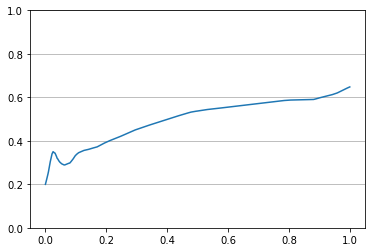

In [322]:
plt.plot(symp_other_x, symp_other_y)
plt.grid(True, axis='y')
plt.ylim([0, 1]) 
plt.show()

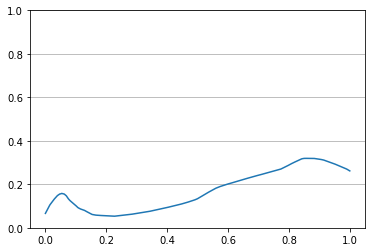

In [323]:
plt.plot(symp_abroad_x, symp_abroad_y)
plt.grid(True, axis='y')
plt.ylim([0, 1]) 
plt.show()

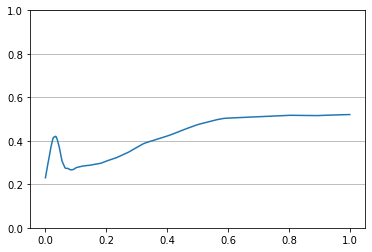

In [324]:
plt.plot(symp_contact_x, symp_contact_y)
plt.grid(True, axis='y')
plt.ylim([0, 1]) 
plt.show()

In [332]:
model.eval()

pred = []
positive_res_data = []
negative_res_data = []
for test_data in tqdm(test_dataloader):
        
    test_inputs, test_labels = test_data
    test_outputs = model(torch.Tensor(test_inputs).to(device))
    if test_outputs[0][0].item() > 0.5:
        pred.append([1])
        positive_res_data.append(test_inputs.numpy().tolist())
    else:
        pred.append([0])
        negative_res_data.append(test_inputs.numpy().tolist())

  0%|          | 0/1069182 [00:00<?, ?it/s]

In [334]:
display_performance_for_dnn(pred, test_gt)

accuracy 0.9231
precision 0.0678
recall 0.6585
f1-score 0.1229
[[981180  79250]
 [  2989   5763]]
[0.         0.65847806 1.        ]
[0.         0.07473383 1.        ]
[2. 1. 0.]
0.5323762760801031
Threshold value is: 1.0


TypeError: plot_roc_curve() missing 1 required positional argument: 'y'

In [329]:
# import pickle 

# with open("./base_pred.pkl", "wb") as fp:
#     pickle.dump(pred, fp)
    
# with open("./base_positive_res_data.pkl", "wb") as fp:
#     pickle.dump(positive_res_data, fp)
    
# with open("./base_negative_res_data.pkl", "wb") as fp:
#     pickle.dump(negative_res_data, fp)

In [330]:
# pred = []
# positive_res_data = []
# negative_res_data = []

# with open("./base_pred.pkl", "rb") as fp:
#     pred = pickle.load(fp)
    
# with open("./base_positive_res_data.pkl", "rb") as fp:
#     positive_res_data = pickle.load(fp)
    
# with open("./base_negative_res_data.pkl", "rb") as fp:
#     negative_res_data = pickle.load(fp)

In [333]:
def display_performance_for_dnn(pred, valid_gt):
    pred = np.array(pred)

    print('accuracy %.4f' % (accuracy_score(pred, valid_gt)))
    print('precision %.4f' % (precision_score(pred, valid_gt)))
    print('recall %.4f' % (recall_score(pred, valid_gt)))
    print('f1-score %.4f' % (f1_score(pred, valid_gt)))
    print(confusion_matrix(pred, valid_gt))
    fper, tper, thresholds = roc_curve(pred, valid_gt)
    print(tper)
    print(fper)
    print(thresholds)
    print(roc_auc_score(valid_gt, pred))
    optimal_idx = np.argmax(tper - fper)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    # plot_roc_curve(fpr, tpr)
    plot_roc_curve(fper, tper)

### 8-feature - epoch 1
- accuracy 0.8779
- precision 0.2652
- recall 0.4887
- f1-score 0.3438

### 8-feature - epoch 10
- accuracy 0.1348
- precision 0.9928
- recall 0.1217
- f1-score 0.2169

### 9-feature(isolated_today_contact_with_confirmed or new_contact_with_confirmed)
- accuracy 0.8793
- precision 0.0000
- 모두 음성으로 판단하는 대참사

### 9-feature(isolated_today_contact_with_confirmed or new_contact_with_confirmed) - epoch 5
- accuracy 0.8699
- precision 0.5792
- recall 0.4685
- f1-score 0.5180

### 9-feature(contact) - epoch 20
- accuracy 0.8702
- precision 0.2208
- recall 0.4144
- f1-score 0.2881

### 9-feature(positive ratio) - epoch 20
- accuracy 0.7904
- precision 0.5766
- recall 0.3010
- f1-score 0.3956

### 10-feature( 'positive_ratio', 'contact') - epoch 20
- accuracy 0.8713
- precision 0.5797
- recall 0.4671
- f1-score 0.5174

### 12-feature('contact', 'positive_ratio', 'weekday_ratio', 'confirmed_ratio') - epoch 20
- accuracy 0.8698
- precision 0.5809
- recall 0.4650
- f1-score 0.5166


accuracy 0.8793
precision 0.1684
recall 0.4877
f1-score 0.2503
[[740307  85788]
 [ 18244  17368]]

In [177]:
# 'cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'confirmed_ratio', 'weekday_ratio', 'corona_result'

In [ ]:
df_pos = pd.DataFrame(np.array(positive_res_data).reshape(-1, 8), columns=['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'test_indication'])
df_neg = pd.DataFrame(np.array(negative_res_data).reshape(-1, 8), columns=['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'test_indication'])

In [ ]:
print(f"양성 갯수: {df_pos.shape[0]}, 음성 갯수: {df_neg.shape[0]}, 양성 / 음성 비율: {round(df_pos.shape[0] / df_neg.shape[0] * 100, 2)}%")

In [ ]:
df_pos_symptom_cnt = [0] * 6
df_neg_symptom_cnt = [0] * 6
pos_symptom_confusion_matrix = np.zeros((2,2,2,2,2), dtype=int)
neg_symptom_confusion_matrix = np.zeros((2,2,2,2,2), dtype=int)

for idx, row in tqdm(df_pos.iterrows()):
    symptoms = row[['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']].astype(int).tolist()
    pos_symptom_confusion_matrix[symptoms[0], symptoms[1], symptoms[2], symptoms[3], symptoms[4]] += 1
    cnt_idx = int(sum(symptoms))
    df_pos_symptom_cnt[cnt_idx] += 1
    
for idx, row in tqdm(df_neg.iterrows()):
    #     if idx == df_pos.shape[0]: break
    symptoms = row[['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']].astype(int).tolist()
    neg_symptom_confusion_matrix[symptoms[0], symptoms[1], symptoms[2], symptoms[3], symptoms[4]] += 1
    cnt_idx = int(sum(symptoms))
    df_neg_symptom_cnt[cnt_idx] += 1

In [ ]:
df_pos.shape[0], df_neg.shape[0]

In [ ]:
def positive_percent_of_ormore_number(number):
    neg_ormore_num = sum(df_neg_symptom_cnt[number:])
    pos_ormore_num = sum(df_pos_symptom_cnt[number:])
    total = neg_ormore_num + pos_ormore_num
    if total == 0: 'lower the number'
    return round((pos_ormore_num / total) * 100, 2)

In [ ]:
print(f"음성 예측 데이터 [0개, 1개, 2개, 3개, 4개, 5개] : {df_neg_symptom_cnt[:6]}")
print(f"양성 예측 데이터 [0개, 1개, 2개, 3개, 4개, 5개] : {df_pos_symptom_cnt[:6]}\n")

for number in range(6):
    print(f"{number}개 이상] {positive_percent_of_ormore_number(number)}% 양성")
    print(f"증상 {number}개] 음성/양성% : {round(df_neg_symptom_cnt[number] / df_pos_symptom_cnt[number]*100, 2)}%\n")

In [ ]:
pos_symptom_confusion_matrix

In [ ]:
def confusion_matrix_display(confusion_matrix):
    for i in range(32):
        idx = bin(i).replace("0b", "0" * (7-len(bin(i))))
        cnt = 0
        if idx[0] == '1': 
            print('[ cough',end = ' ')
            cnt += 1
        if idx[1] == '1': 
            print('fever',end = ' ')
            cnt += 1
        if idx[2] == '1': 
            print('sore_throat',end = ' ')
            cnt += 1
        if idx[3] == '1': 
            print('shortness_of_breath',end = ' ')
            cnt += 1
        if idx[4] == '1': 
            print('head_ache',end = ' ')
            cnt += 1
        print(f'{cnt}개 증상 ]')
            
        print(confusion_matrix[int(idx[0]),int(idx[1]),int(idx[2]),int(idx[3]),int(idx[4])])

In [ ]:
confusion_matrix_display(neg_symptom_confusion_matrix)

In [ ]:
confusion_matrix_display(pos_symptom_confusion_matrix)

In [ ]:
pred = np.array(pred)

print('accuracy %.4f' % (accuracy_score(pred, valid_gt)))
print('precision %.4f' % (precision_score(pred, valid_gt)))
print('recall %.4f' % (recall_score(pred, valid_gt)))
print('f1-score %.4f' % (f1_score(pred, valid_gt)))
print(confusion_matrix(pred, valid_gt))

In [ ]:
pred
# pred_chk

### random forest result
- accuracy 0.9257
- precision 0.2314
- recall 0.5553
- f1-score 0.3267
- [[791936  52206]
- [ 12591  15720]]

### 1-layer sigmoid epoch3 result
- accuracy 0.9222
- precision 0.1958
- recall 0.5013
- f1-score 0.2816
- [[791299  54627]
- [ 13228  13299]]

### compare with logistic regression
- accuracy 0.9224
- precision 0.1953
- recall 0.5049
- f1-score 0.2816
- [[791517  54661]
- [ 13010  13265]]

### 2-layer epoch3 result
- 8-4-1(sig-sig)
- accuracy 0.9248
- precision 0.2626
- recall 0.5342
- f1-score 0.3521
- [[788976  50090]
-  [ 15551  17836]]

### 2-layer epoch3 result
- 8-4-1(relu-sig)
- accuracy 0.9256 
- precision 0.1999
- recall 0.5635
- f1-score 0.2951
- [[794008  54349]
- [ 10519  13577]]

### 2-layer epoch3 result
- 8-20-1(relu-sig)
- accuracy 0.9255
- precision 0.2392
- recall 0.5498
- f1-score 0.3333
- [[791226  51680]
-  [ 13301  16246]]

### 2-layer epcoh3 result 
- 8-400-1(relu-sig)
- accuracy 0.9256
- precision 0.2904
- recall 0.5415
- f1-score 0.3781
- [[787821  48197]
- [ 16706  19729]]

### 3-layer epoch3 result
- 8-4-2-1 (relu-relu-sigmoid) (sigmoid-sigmoid-sigmoid 동일한 결과)
- accuracy 0.9221
- precision 0.0000
- recall 0.0000
- f1-score 0.0000
- [[804527  67926]
-  [     0      0]]
- 확인 결과 모든 출력을 음성으로 출력함(1-layer가 오히려 낫네?)

## 시간 순서대로 train, valid, test 나눔

### Logistic Regression
- accuracy 0.8782
- precision 0.2240
- recall 0.4901
- f1-score 0.3075
- [[742649  81690]
  [ 24533  23581]]
  
### Random Forest
- accuracy 0.8761
- precision 0.4298
- recall 0.4848
- f1-score 0.4556
- [[719101  60026]
- [ 48081  45245]]

### Decision Tree
- accuracy 0.8761
- precision 0.4299
- recall 0.4848
- f1-score 0.4557
- [[719094  60017]
- [ 48088  45254]]

### Gradient Boosting 
- accuracy 0.8789
- precision 0.3059
- recall 0.4973
- f1-score 0.3788
- [[734633  73070]
- [ 32549  32201]]

### 3-layer NN 
- epochs = 10, batch_size = 128
- 8-1200-1
- accuracy 0.8699
- precision 0.5794
- recall 0.4683
- f1-score 0.5180
- [[697921  44274]
- [ 69261  60997]]